# Le Convolutional Neural Network avec PyTorch

Le deep learning a révolutionné les techniques d'analyse dans de nombreux domaines de la data, notamment l'analyse d'images, où il est rapidement devenu la méthode de référence. Les réseaux de neurones convolutifs (CNN) jouent un rôle central dans ce progrès, permettant aux algorithmes d'extraire efficacement des informations pertinentes des images. Dans ce notebook, nous allons explorer comment initialiser et entraîner des modèles CNN avec TensorFlow

## Résolution du problème CIFAR-10

Le jeu de données CIFAR-10 contient 60 000 images en couleur de dimensions 32x32, réparties en 10 classes distinctes, avec 6 000 images par classe. Chaque classe est exclusive, ce qui signifie qu'il n'y a qu'un seul objet par image

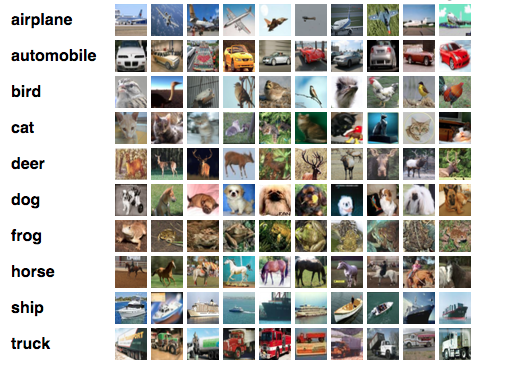

L'objectif est d'entraîner un modèle capable de classer les images en fonction de l'objet qu'elles représentent. Pour ce faire, le jeu de données est divisé en deux ensembles : un ensemble d'entraînement avec 50 000 images et un ensemble de test avec 10 000 images.

## Importations des bibliothèques

In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from collections import OrderedDict

import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

## Importation des données

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:04<00:00, 41.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
images, labels = next(iter(testloader))
print(images.shape)
print(labels.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4])


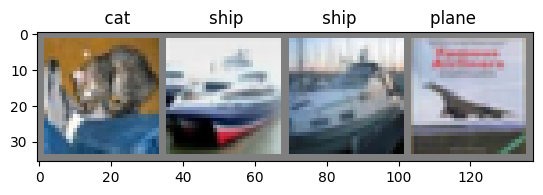

In [ ]:
img = torchvision.utils.make_grid(images).numpy()
img = img / 2 + 0.5
npimg = np.transpose(img, (1, 2, 0))

plt.imshow(npimg)
plt.title('              '.
          join('%5s' % classes[labels[j]] for j in range(batch_size)))

plt.show()

# D'une image à un tenseur

Comme vous pouvez le voir ci-dessous, nos images sont encodées sous forme de tenseurs en trois dimensions : 3x32x32. Cependant, les images elles-mêmes mesurent 32 pixels de hauteur et 32 pixels de largeur.

In [ ]:
print(images[0].shape)

torch.Size([3, 32, 32])


D'où provient cette troisième dimension ? Elle correspond au fait que, pour encoder les couleurs des images, nous ne disposons pas d'un unique chiffre par couleur. Chaque pixel est représenté par un mélange d'intensités des trois couleurs primaires : rouge, bleu et vert. Comme illustré ci-dessous, ces trois composantes permettent de recréer toutes les couleurs visibles dans les images.

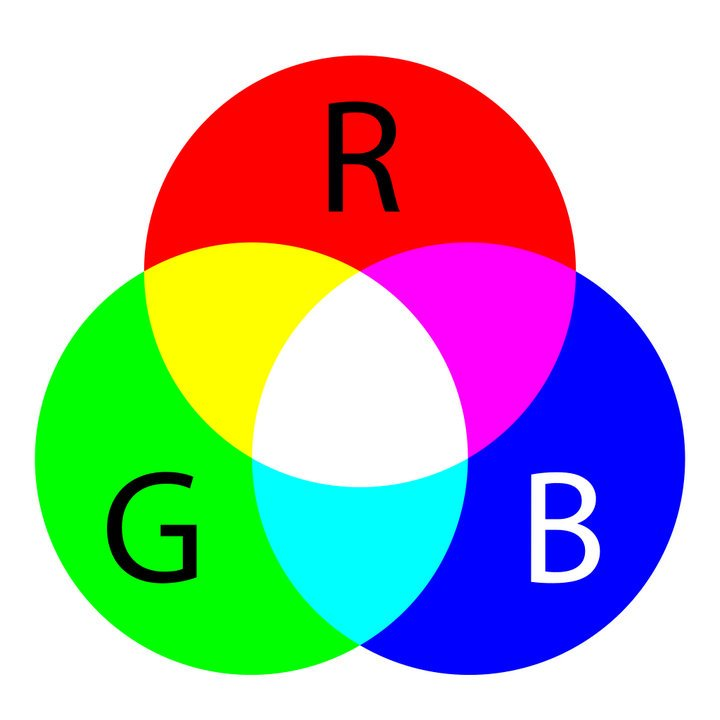

Comme illustré ci-dessous, l'image est décomposée en trois matrices de la même taille que l'image d'origine, chacune représentant les intensités d'une couleur différente. C'est ce tenseur en trois dimensions qui constitue la représentation complète de notre image.

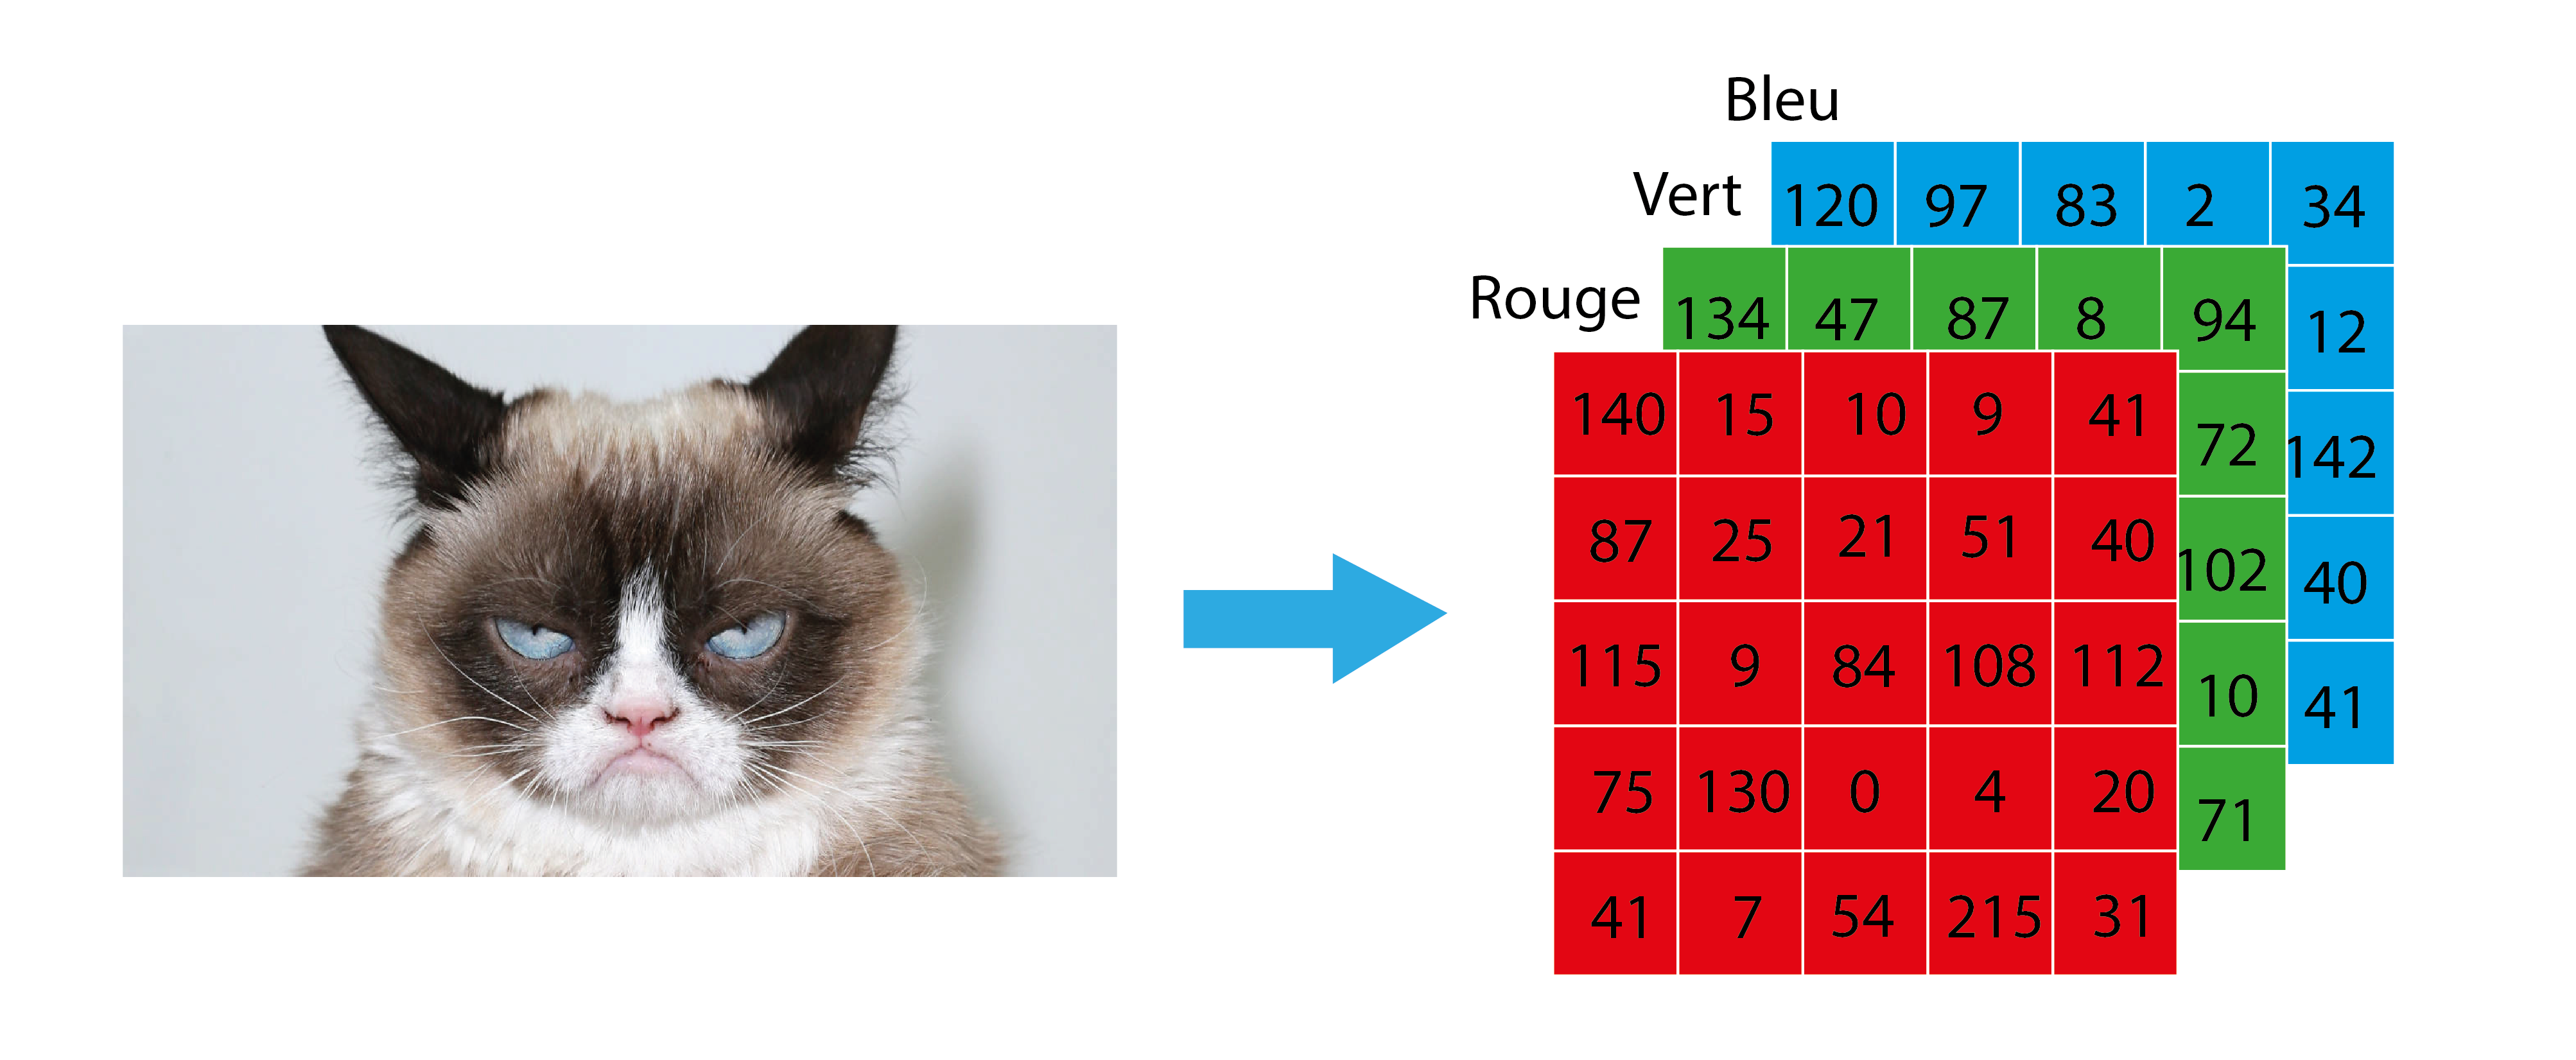

## Les couches du CNN avec Pytorch

Pour construire notre architecture de CNN on va avoir besoin de deux nouvelles fonctions `Conv2d` pour les opérations de convolution et `MaxPool2d` pour les opérations de pooling.

### Les convolutions

La convolution est une opération qui applique un filtre (ou patch) sur l'image pour en extraire des caractéristiques, permettant ainsi de les représenter dans un format exploitable par notre modèle. Le schéma ci-dessous illustre cette opération de convolution sur une image.

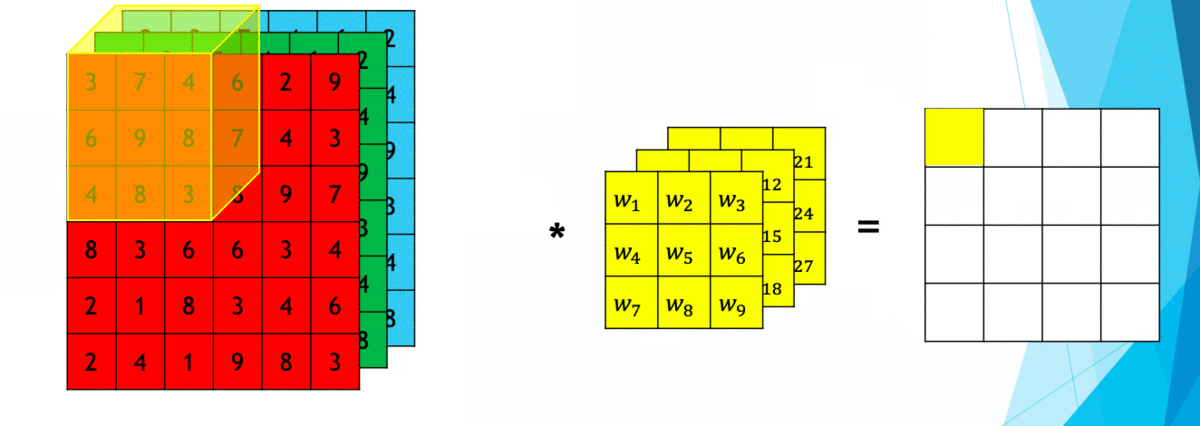

La fonction Conv2d possède plusieurs paramètres, mais nous allons ici nous concentrer sur les plus importants pour ce notebook.

- `in_channels` correspond au nombre de canaux en entrée de la couche précédente.
- `out_channels` détermine le nombre de filtres appliqués par la couche, donc le nombre de canaux en sortie.
- `kernel_size` spécifie la taille des filtres de convolution.

Initialisons notre convolution.

Créez une opération de convolution avec :
- 8 filtres ;
- des filtres de 3 pixels de côté.

Adiez-vous de la [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

In [ ]:
test_conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)

Appliquons notre convolution à un batch d'images.

In [ ]:
prediction_conv = test_conv(images)

On peut voir que le nombre de channels est bien de 8 maintenant.

In [ ]:
print(images.shape)
print(prediction_conv.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4, 8, 30, 30])


### Le Pooling

L'opération de pooling permet de réduire la dimension de nos images tout en gardant l'essentiel de l'information. comme vous pouvez le voir ci-dessous il suffit de prendre l'image par zone et de garder les intensités maximum.

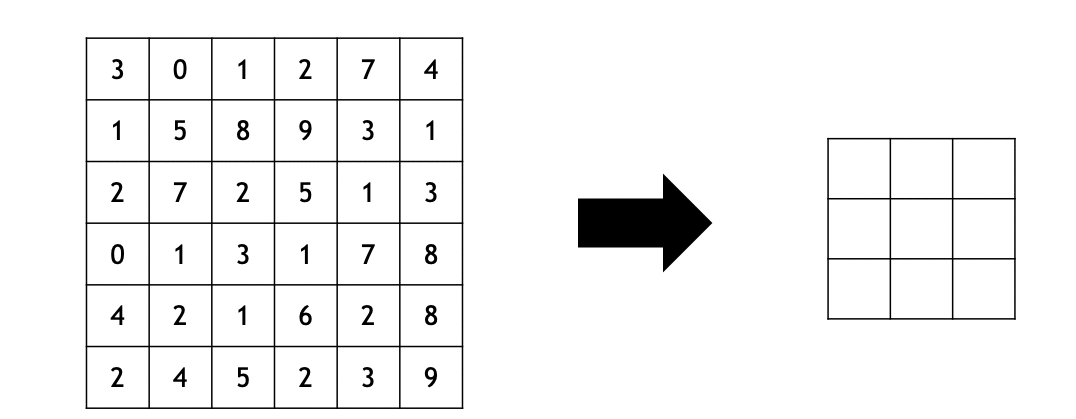

La fonction `MaxPool2d` possède quelques paramètres, ici on va seulement aborder les plus important pour le problème de ce notebook.

**kernel size** est la dimension de la fenêtre qui va parcourir notre image afin de retirer les intensités maximums.

**stride** est le pas de déplacement de notre fenêtre sur notre image.

Initialisons notre fonction de *pooling*.

Créez une opération de pooling avec :
- un stride de 2 ;
- une taille de 2 pixels de côté.

Aidez-vous de la [documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

In [ ]:
test_pooling = nn.MaxPool2d(kernel_size=2, stride=2)

Appliquons cette opération à notre batch d'images.

In [ ]:
prediction_pooling = test_pooling(images)

On constate que le nombre de canaux reste inchangé, mais la taille de notre image a été réduite de moitié.

In [ ]:
print(images.shape)
print(prediction_pooling.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 16, 16])


Si nous visualisons à nouveau nos images, nous pouvons constater qu'elles sont moins détaillées qu'auparavant.

Avant Pooling


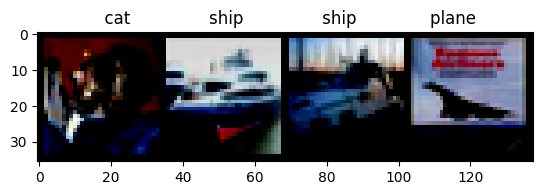

Après pooling


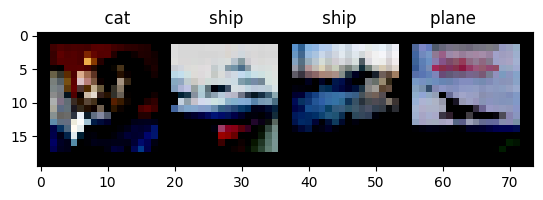

In [ ]:
print('Avant Pooling')
img = torchvision.utils.make_grid(images).numpy()
npimg = np.transpose(img, (1, 2, 0))

plt.imshow(npimg)
plt.title('              '.
          join('%5s' % classes[labels[j]] for j in range(batch_size)))

plt.show()

print('Après pooling')
img = torchvision.utils.make_grid(prediction_pooling).numpy()
npimg = np.transpose(img, (1, 2, 0))

plt.imshow(npimg)
plt.title('              '.
          join('%5s' % classes[labels[j]] for j in range(batch_size)))

plt.show()

## Un modèle de classification d'images

Nous avons maintenant vue toutes les fonctions dont nous avons besoin pour initialiser et entraîner un modèle de deep learning capable de résoudre notre problème de classification.

### Initialiser votre modèle

Initialisez un modèle avec :
- une couche de convolution avec 32 filtres de 3 pixels de côté (ReLU) ;
- une couche de maxpooling de 2 de côté ;
- une couche de convolution avec 64 filtres de 3 pixels de côté (ReLU) ;
- une couche de maxpooling de 2 de côté ;
- une couche de convolution avec 64 filtres de 3 pixels de côté (ReLU) ;
- transformer les images en vecteur avec la fonction *Flatten* (documentation [texte du lien](https://pytorch.org/docs/stable/generated/torch.flatten.html))
- Une couche complétement connecté de 64 neurones (ReLU) ;
- une couche de sortie avec 10 neurones (LogSoftmax).


In [ ]:
model = torch.nn.Sequential(OrderedDict([('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)),
                                         ('relu1', nn.ReLU()),
                                         ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
                                         ('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                                         ('relu2', nn.ReLU()),
                                         ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
                                         ('flatten', nn.Flatten()),
                                         ('fc1', nn.Linear(2304, 64)),
                                         ('relu3', nn.ReLU()),
                                         ('output', nn.Linear(64, 10)),
                                         ('softmax', nn.LogSoftmax(dim=1))]))


print(model)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2304, out_features=64, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
              ReLU-2           [-1, 32, 30, 30]               0
         MaxPool2d-3           [-1, 32, 15, 15]               0
            Conv2d-4           [-1, 64, 13, 13]          18,496
              ReLU-5           [-1, 64, 13, 13]               0
         MaxPool2d-6             [-1, 64, 6, 6]               0
           Flatten-7                 [-1, 2304]               0
            Linear-8                   [-1, 64]         147,520
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
       LogSoftmax-11                   [-1, 10]               0
Total params: 167,562
Trainable params: 167,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

### Définir la fonction de coût

On va choisir la *cross entropy loss* qui est la plus utilisait dans les problèmes de classificaiton multi-classes.

In [ ]:
criterion = nn.NLLLoss()

### Choisir l'algorithme d'optimisation

Nous allons utiliser un algorithme d'optimisation classique, le *Sotchastic gradient descent*.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Entraîner le modèle

In [ ]:
epoch = 5

for e in range(epoch):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.732
[1,  4000] loss: 1.455
[1,  6000] loss: 1.378
[1,  8000] loss: 1.311
[1, 10000] loss: 1.259
[1, 12000] loss: 1.190
[2,  2000] loss: 1.112
[2,  4000] loss: 1.096
[2,  6000] loss: 1.080
[2,  8000] loss: 1.074
[2, 10000] loss: 1.054
[2, 12000] loss: 1.077
[3,  2000] loss: 0.946
[3,  4000] loss: 0.954
[3,  6000] loss: 0.981
[3,  8000] loss: 0.973
[3, 10000] loss: 0.976
[3, 12000] loss: 0.961
[4,  2000] loss: 0.877
[4,  4000] loss: 0.893
[4,  6000] loss: 0.888
[4,  8000] loss: 0.894
[4, 10000] loss: 0.897
[4, 12000] loss: 0.898
[5,  2000] loss: 0.818
[5,  4000] loss: 0.833
[5,  6000] loss: 0.843
[5,  8000] loss: 0.846
[5, 10000] loss: 0.843
[5, 12000] loss: 0.850
Finished Training


## Calculer les performances du modèles

### Test sur 5 exemples

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

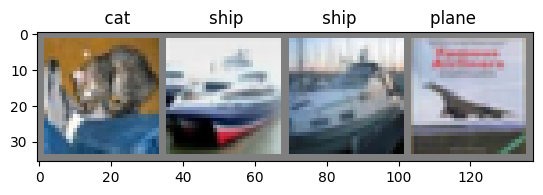

In [ ]:
img = torchvision.utils.make_grid(images).numpy()
img = img / 2 + 0.5
npimg = np.transpose(img, (1, 2, 0))

plt.imshow(npimg)
plt.title('              '.
          join('%5s' % classes[labels[j]] for j in range(batch_size)))

plt.show()

In [ ]:
_, predicted = torch.max(model(images), 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


On peut voir qu'après 5 itérations notre modèle commence à reconnaître certaines images.

### Test sur le jeu de données de test

On va tester sur le modèle sur le jeu de test.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


On voit qu'après quelques itérations le modèle commence par apprendre comment classifier nos images.

### Test par classe

On va maintenant tester la performance de notre modèle sur chacune des classes.

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 79 %
Accuracy of  bird : 47 %
Accuracy of   cat : 60 %
Accuracy of  deer : 56 %
Accuracy of   dog : 37 %
Accuracy of  frog : 75 %
Accuracy of horse : 78 %
Accuracy of  ship : 83 %
Accuracy of truck : 72 %


On peut voir ici que notre modèle n'a pas la même performance à classifier toutes nos classes.